# Прогнозирование уровня средней заработной платы в России 

In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

Populating the interactive namespace from numpy and matplotlib


## Загрузка данных

In [2]:
wage = pd.read_csv('WAG_C_M.csv', sep=';', index_col=['month'], parse_dates=['month'], dayfirst=True)
wage.columns = ['wage']

## Визуализация данных

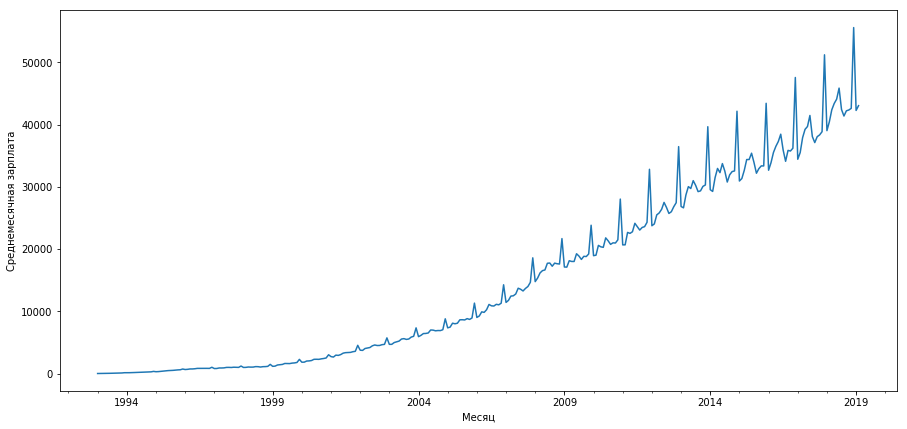

In [3]:
plt.figure(figsize=(15, 7))
wage['wage'].plot()
plt.ylabel('Среднемесячная зарплата')
plt.xlabel('Месяц')
pylab.show()

## Анализ и стабилизация

In [4]:
print("Критерий Дики-Фуллера: p = %f" % sm.tsa.stattools.adfuller(wage['wage'])[1])

Критерий Дики-Фуллера: p = 0.998363


<Figure size 1080x720 with 0 Axes>

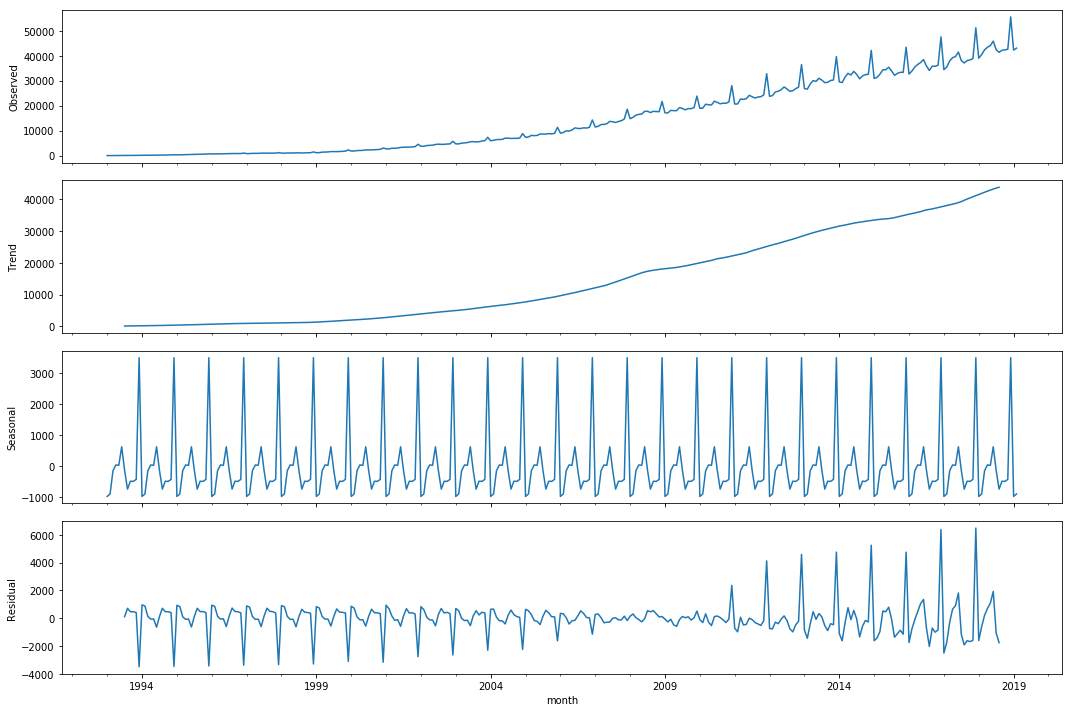

In [5]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(wage['wage']).plot()
plt.show()

Необходимо стабилизировать дисперсию. Сделаем это с помощью преобразования Бокса-Кокса.

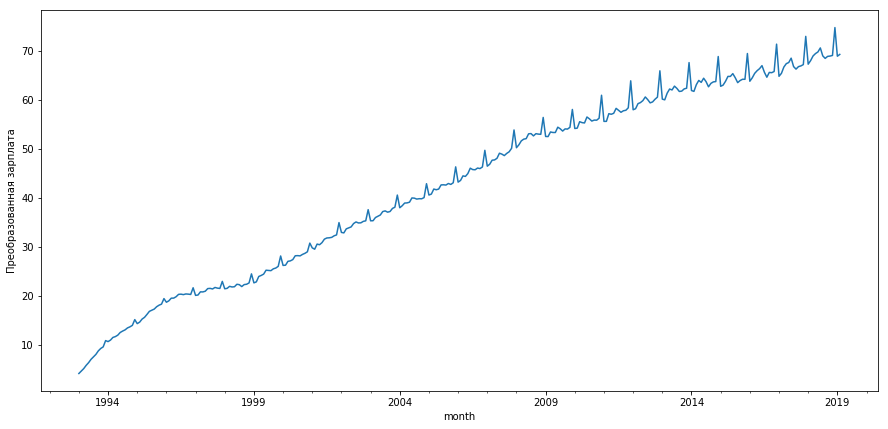

In [6]:
wage['box'], lmbda = stats.boxcox(wage['wage'])
plt.figure(figsize=(15, 7))
wage['box'].plot()
plt.ylabel('Преобразованная зарплата')
plt.show()

In [7]:
print('Оптимальный параметр преобразования Бокса-Кокса: %f' % lmbda)
print('Критерий Дики-Фуллера: p = %f' % sm.tsa.stattools.adfuller(wage['box'])[1])

Оптимальный параметр преобразования Бокса-Кокса: 0.283780
Критерий Дики-Фуллера: p = 0.719150


Ряд по-прежнему нестационарен. Имеется явный восходящий тренд.

Применим сезонное дифференцирование и проверим стационарность.

<Figure size 1080x720 with 0 Axes>

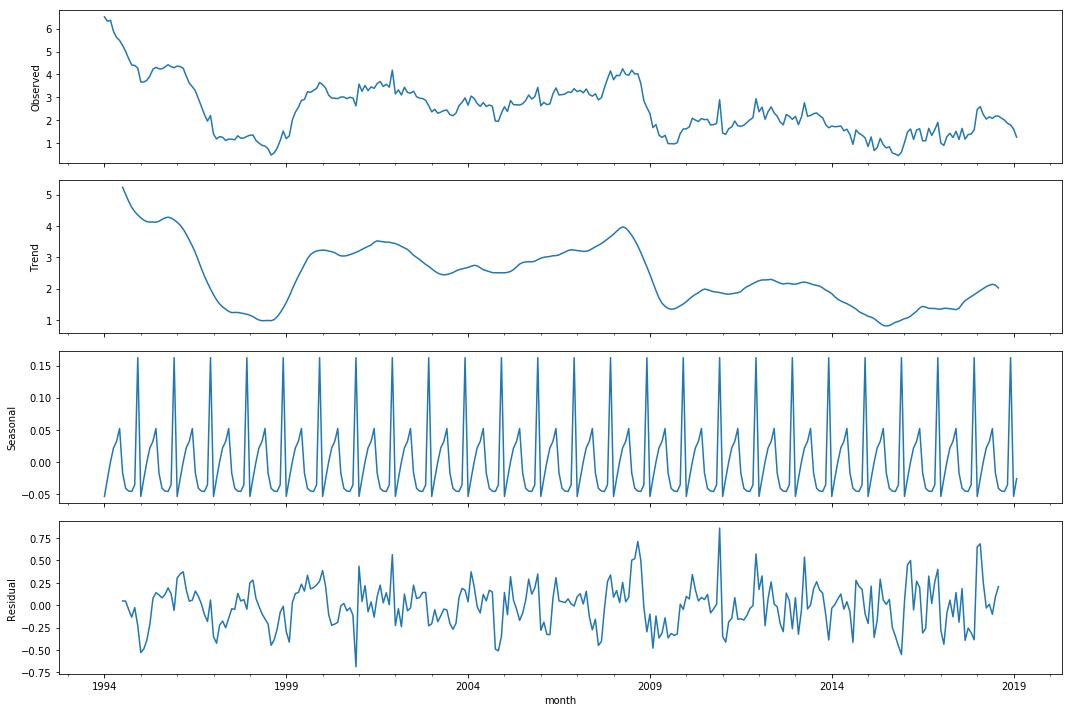

In [8]:
wage['box_diff'] = wage['box'] - wage['box'].shift(12)
plt.figure(figsize=(15, 10))
sm.tsa.seasonal_decompose(wage['box_diff'][12:]).plot()
plt.show()

In [9]:
print('Критерий Дики-Фуллера: p = %f' % sm.tsa.stattools.adfuller(wage['box_diff'][12:])[1])

Критерий Дики-Фуллера: p = 0.148389


Критерий Дики-Фуллера не отвергает гипотезу нестационарности, да и на графике явно виден тренд. Попробуем добавить дифференцирование.

<Figure size 1080x720 with 0 Axes>

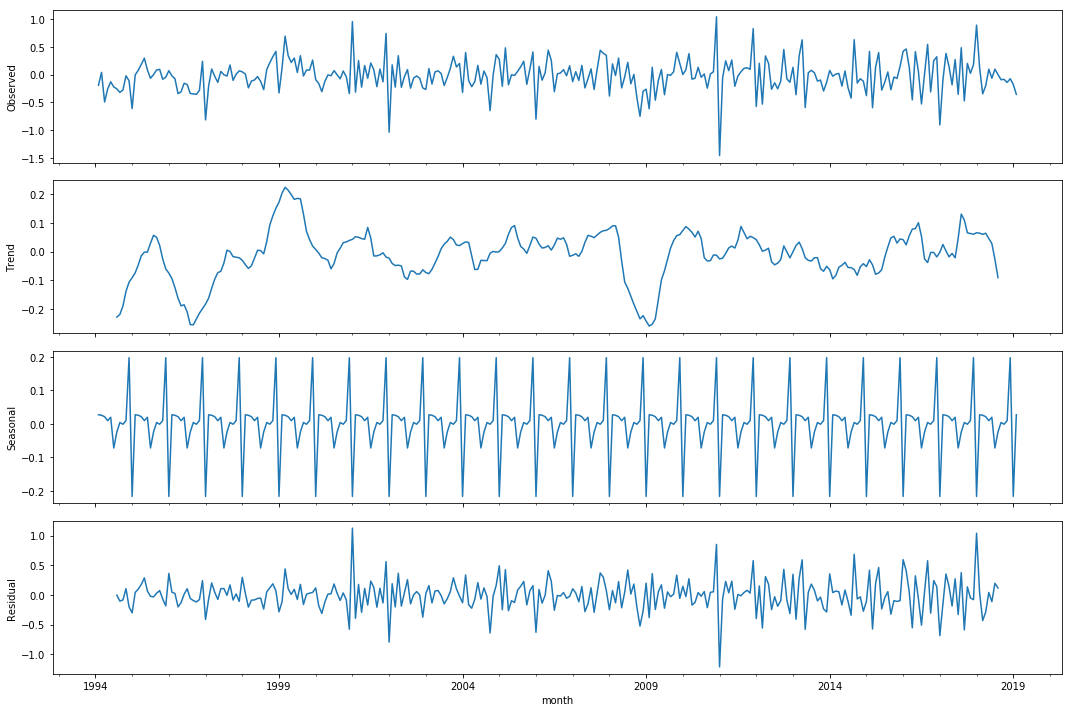

In [10]:
wage['box_diff2'] = wage['box_diff'] - wage['box_diff'].shift(1)
plt.figure(figsize=(15, 10))
sm.tsa.seasonal_decompose(wage['box_diff2'][13:]).plot()
plt.show()

In [11]:
print('Критерий Дики-Фуллера: p = %f' % sm.tsa.stattools.adfuller(wage['box_diff2'][13:])[1])

Критерий Дики-Фуллера: p = 0.000000


Теперь гипотеза нестационарности отвергается, визуально тренд не просматривается. Можно переходить к подбору модели.

## Выбор начальных приближений для $p,q,P,Q$

Выведем ACF и PACF полученного ряда.

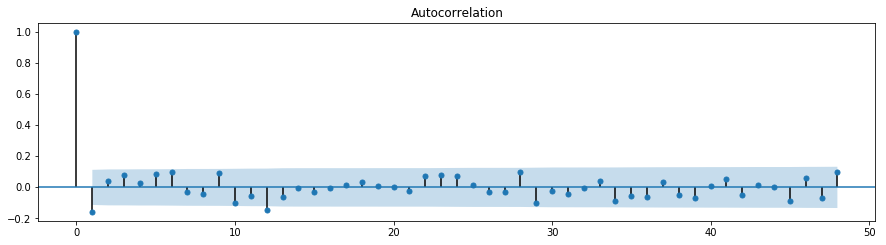

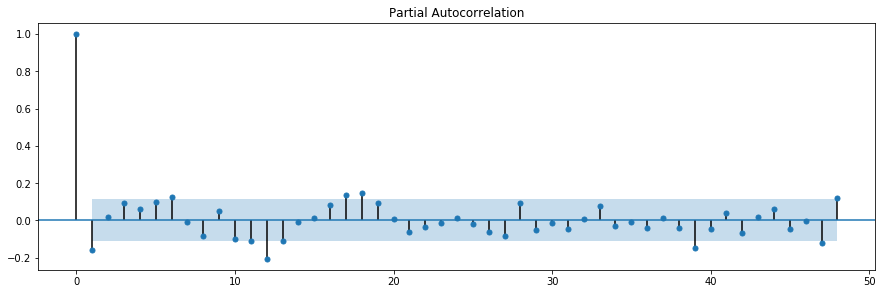

In [12]:
plt.figure(figsize=(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(wage['box_diff2'][13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(wage['box_diff2'][13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Начальные приближения: $Q=1, q=2, P=1, p=6$



In [13]:
Qs = range(2)
qs = range(3)
Ps = range(2)
ps = range(7)
d = 1
D = 1

In [14]:
parameters = list(product(ps, qs, Ps, Qs))

## Обучение и сравнение моделей-кандидатов, выбор победителя

In [15]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(wage['box'], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (2, 1, 0, 0)
wrong parameters: (2, 1, 0, 1)
wrong parameters: (2, 1, 1, 0)
wrong parameters: (2, 1, 1, 1)
wrong parameters: (3, 2, 0, 0)
wrong parameters: (3, 2, 0, 1)
wrong parameters: (3, 2, 1, 0)
wrong parameters: (3, 2, 1, 1)
wrong parameters: (4, 2, 0, 0)
wrong parameters: (4, 2, 0, 1)
wrong parameters: (4, 2, 1, 0)
wrong parameters: (4, 2, 1, 1)
wrong parameters: (5, 2, 0, 0)
wrong parameters: (5, 2, 0, 1)
wrong parameters: (5, 2, 1, 0)
wrong parameters: (5, 2, 1, 1)
CPU times: user 8min 15s, sys: 672 ms, total: 8min 16s
Wall time: 1min 47s


In [16]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters         aic
59  (6, 0, 1, 1)  106.875670
23  (1, 2, 1, 1)  107.939068
58  (6, 0, 1, 0)  108.239792
63  (6, 1, 1, 1)  108.566226
22  (1, 2, 1, 0)  109.153234


Выберем набор (0, 2, 1, 1) т.к. он имеет ощутимо меньшие величины параметров, чем лучшая модель, при незначительном увеличении критерия Акаике

In [17]:
warnings.filterwarnings('ignore')
param = parameters[23]
model = best_model
model=sm.tsa.statespace.SARIMAX(wage['box'], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)

In [18]:
print(model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                box   No. Observations:                  314
Model:             SARIMAX(1, 1, 2)x(1, 1, 1, 12)   Log Likelihood                 -47.970
Date:                            Fri, 05 Apr 2019   AIC                            107.939
Time:                                    14:26:51   BIC                            130.182
Sample:                                01-01-1993   HQIC                           116.840
                                     - 02-01-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8225      0.142      5.788      0.000       0.544       1.101
ma.L1         -1.0904      0.140   

## Анализ остатков построенной модели

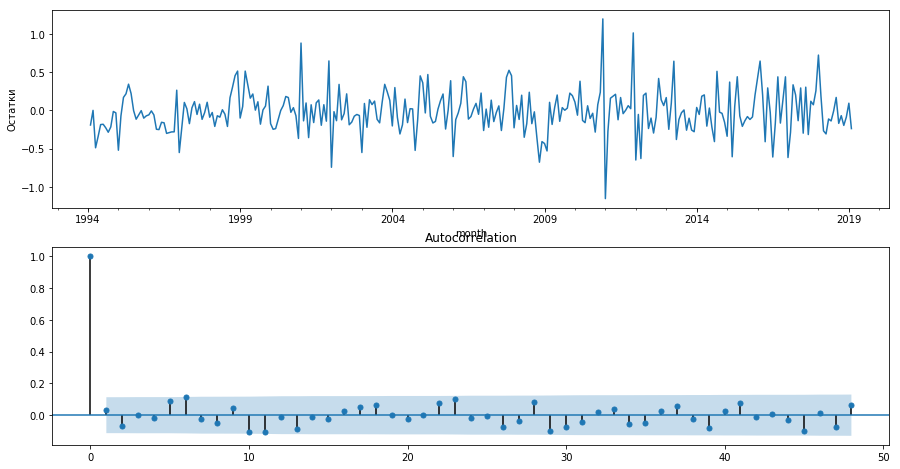

In [19]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel('Остатки')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(model.resid[13:].values.squeeze(), lags=48, ax=ax)
plt.show();

In [20]:
print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(model.resid[13:])[1])

Критерий Стьюдента: p=0.357867
Критерий Дики-Фуллера: p=0.000000


Критерий Стьюдента показывает, что остатки несмещены.

Критерий Дики-Фуллера и визуальные данные показывают, что остатки стационарны.

Кореллограмма показывает, что нет значимой автокорелляции остатков.

Наложим модель на данные.

In [21]:
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

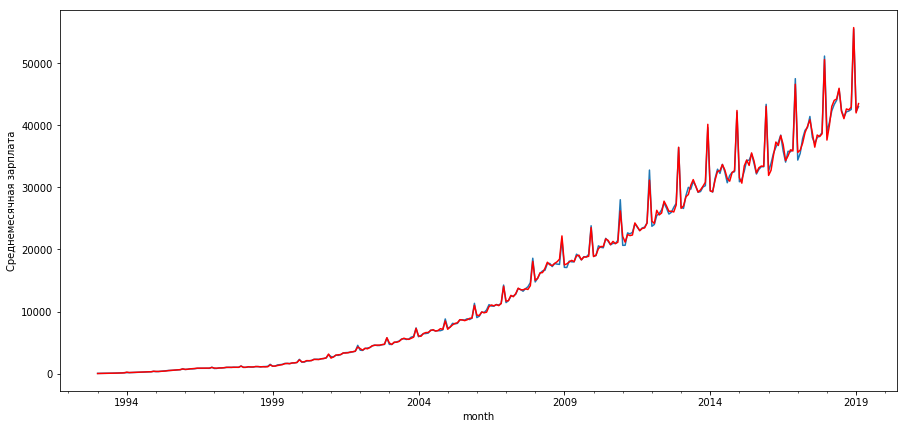

In [22]:
wage['model'] = invboxcox(model.fittedvalues, lmbda)
plt.figure(figsize=(15,7))
wage['wage'].plot()
wage['model'].plot(color='r')
plt.ylabel('Среднемесячная зарплата')
pylab.show();

## Прогнозирование с помощью финальной модели

In [23]:
wage.index[-1]

Timestamp('2019-02-01 00:00:00')

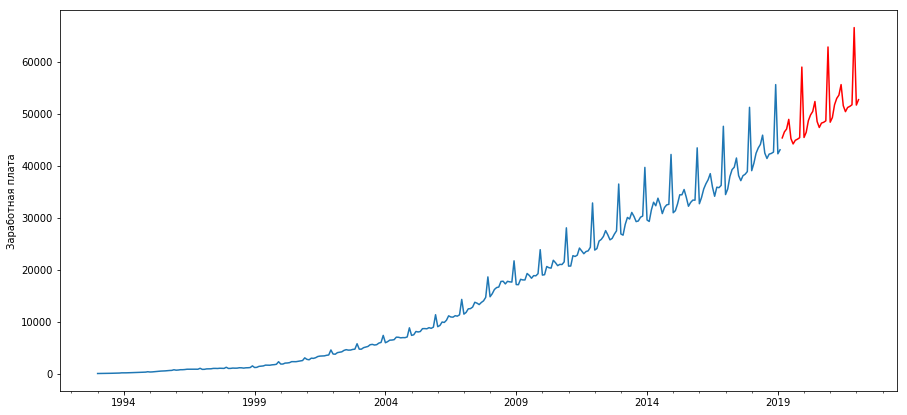

In [24]:
wage2 = wage[['wage']]
date_list = [datetime.datetime.strptime('2019-03-01', "%Y-%m-%d") + relativedelta(months=x) for x in range(36)]
future = pd.DataFrame(index=date_list, columns=wage2.columns)
wage2 = pd.concat([wage2, future])
wage2['forecast'] = invboxcox(model.predict(start=wage.shape[0], end=wage.shape[0]+35), lmbda)

plt.figure(figsize=(15,7))
wage2['wage'].plot()
wage2['forecast'].plot(color='r')
# wage_val['wage'].plot(color='g')
plt.ylabel('Заработная плата')
pylab.show();

Предсказания модели выглядят правдоподобно